In [201]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

In [202]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, make_scorer

# Import train & test data

In [203]:
b_train = pd.read_csv('data/b_train.csv')
b_train.describe()

,outcome,mean_time_diff,total_bids_count,total_auctions_count,mean_response,min_response
count,2013.000000,1.682000e+03,2013.000000,2013.000000,1983.000000,1983.000000
mean,0.051167,6.080752e+04,1525.694983,61.684054,1417.833629,29.442259
std,0.220394,1.551962e+05,14596.346369,146.431311,10203.707395,202.225500
min,0.000000,1.350000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.211277e+03,3.000000,2.000000,33.000000,0.000000
50%,0.000000,1.106926e+04,17.000000,10.000000,142.000000,0.000000
75%,0.000000,4.829749e+04,200.000000,45.000000,493.795200,4.000000
max,1.000000,1.445956e+06,515033.000000,1623.000000,318302.500000,4242.000000


In [204]:
b_test = pd.read_csv('data/b_test.csv')
b_test.describe()

,mean_time_diff,total_bids_count,total_auctions_count,mean_response,min_response
count,3.875000e+03,4700.000000,4700.000000,4.627000e+03,4.627000e+03
mean,6.865193e+04,975.555319,54.930000,1.811766e+03,5.384668e+02
std,1.832103e+05,6182.458895,123.740628,2.404411e+04,2.124275e+04
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.290090e+03,2.000000,2.000000,3.300000e+01,0.000000e+00
50%,9.564203e+03,17.000000,9.000000,1.512974e+02,0.000000e+00
75%,4.518996e+04,171.250000,46.000000,5.663539e+02,4.000000e+00
max,1.439525e+06,168995.000000,1726.000000,1.084161e+06,1.084161e+06


# RandomForest model

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [179]:
b_train = b_train.dropna()
b_test = b_test.dropna()

full_features = ['mean_time_diff', 'total_bids_count', 'total_auctions_count', 'mean_response', 'min_response']
features = ['mean_time_diff', 'total_bids_count', 'total_auctions_count', 'mean_response']
target = ['outcome']

X = np.array(b_train[features])
y = np.array(b_train[target]).ravel()
print('X.shape = {}\ny.shape = {}'.format(X.shape, y.shape))

X_submission = np.array(b_test[features])
print('X_submission.shape = {}'.format(X_submission.shape))

X.shape = (1682, 4)
y.shape = (1682,)
X_submission.shape = (3875, 4)


### Split data

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_test_transformed = np.hstack((1 - y_test.reshape(y_test.size,1),
                                y_test.reshape(y_test.size,1)))

### Train model

Choose the parameter max_depth

In [181]:
auc_list = []
for i in range(1,100):
    RF_classifier = RandomForestClassifier(max_depth=i, random_state=0)
    RF_classifier.fit(X_train, y_train)
    auc_list.append(roc_auc_score(y_test_transformed, RF_classifier.predict_proba(X_test), average='weighted'))
best_max_depth = np.array(auc_list).argmax() + 1
print('best max_depth = {}'.format(best_max_depth)) # 2
print('roc-auc for it = {}'.format(np.array(auc_list).max()))

best max_depth = 8
roc-auc for it = 0.8762851731601732


Fit model

In [188]:
RF_classifier = RandomForestClassifier(max_depth=best_max_depth, random_state=0)
RF_classifier.fit(X_train, y_train)

print(RF_classifier.feature_importances_)

y_pred = RF_classifier.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print('accuracy = {}'.format(acc_score))


y_score = RF_classifier.predict_proba(X_test)
auc_score = roc_auc_score(y_test_transformed, y_score, average='weighted')
print('roc-auc = {}'.format(auc_score))

[ 0.5657629   0.28393688  0.09796028  0.05233994]
accuracy = 0.9496402877697842
roc-auc = 0.8747294372294372


draw ROC curve

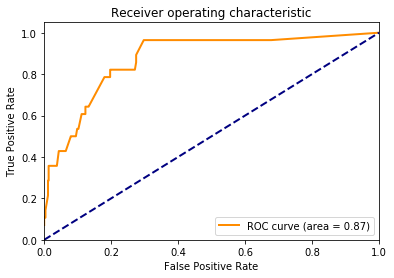

In [189]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_transformed[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area for 1
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Cross validation

In [184]:
CV_SSS = model_selection.StratifiedShuffleSplit(n_splits = 6, test_size = 0.33, random_state=1)
#for train_indices, test_indices in CV_SSS.split(X, y):
    #print(train_indices, test_indices)
    
RF_classifier = RandomForestClassifier(max_depth=best_max_depth, random_state=3)
RF_cross_val_scoring = cross_val_score(RF_classifier, X, y, scoring='roc_auc', cv=CV_SSS)
print(RF_cross_val_scoring)
print('mean: {:.4f}, max: {:.4f}, min: {:.4f}, std: {:.4f}'.format(RF_cross_val_scoring.mean(),
                                                               RF_cross_val_scoring.max(), 
                                                               RF_cross_val_scoring.min(),
                                                               RF_cross_val_scoring.std()))

[ 0.90094227  0.87756441  0.88442271  0.90961951  0.88403507  0.85025048]
mean: 0.8845, max: 0.9096, min: 0.8503, std: 0.0188


([4, 4, 3, 3, 3, 3, 5, 4, 6, 6, 5, 3, 6, 5, 4, 6, 3, 5, 4],
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fafc978>]], dtype=object))

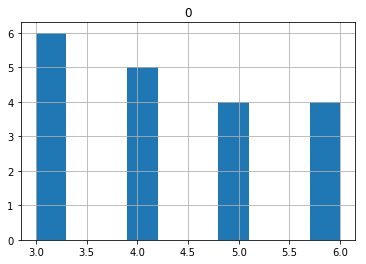

In [185]:
global_depth = []
for j in range(1,20):
    CV_SSS = model_selection.StratifiedShuffleSplit(n_splits = 6, test_size = 0.33, random_state=None)
    auc_list = []
    for i in range(1,10):
        RF_classifier = RandomForestClassifier(max_depth=i, random_state=None)
        RF_cross_val_scoring = cross_val_score(RF_classifier, X, y, scoring='roc_auc', cv=CV_SSS)
        auc_list.append(RF_cross_val_scoring.mean())
    best_max_depth = np.array(auc_list).argmax() + 1
    #print('best max_depth = {}'.format(best_max_depth)) # 2
    #print('roc-auc for it = {}'.format(np.array(auc_list).max()))
    global_depth.append(best_max_depth)
global_depth, pd.DataFrame(global_depth).hist()

In [194]:
best_max_depth = 3
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Predict on test data to submission

In [195]:
submission_prediction = RF_classifier.predict_proba(X_submission)[:,1]
print(submission_prediction)

[ 0.00067797  0.00135402  0.04976017 ...,  0.16735064  0.00067797
  0.05788644]


In [196]:
b_test['prediction'] = submission_prediction
b_test.head()

,bidder_id,mean_time_diff,total_bids_count,total_auctions_count,mean_response,min_response,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,444750.0000,4,3,16.7500,0.0,0.000678
1,a921612b85a1494456e74c09393ccb65ylp4y,722019.5000,3,2,371.3333,2.0,0.001354
2,6b601e72a4d264dab9ace9d7b229b47479v6i,345.6250,17,14,186.3529,0.0,0.049760
3,eaf0ed0afc9689779417274b4791726cn5udi,9890.5510,148,90,7762.0946,0.0,0.005289
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,5678.2273,23,20,9168.6957,16.0,0.004820


In [197]:
b_test_RF = pd.read_csv('data/SubmissionRF2_3.csv')
b_test_RF.head()

,bidder_id,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,0.002804
1,a921612b85a1494456e74c09393ccb65ylp4y,0.002804
2,6b601e72a4d264dab9ace9d7b229b47479v6i,0.085325
3,eaf0ed0afc9689779417274b4791726cn5udi,0.042377
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,0.002536


In [198]:
for bidder in b_test_RF.bidder_id:
    if (bidder in list(b_test.bidder_id)):
        #print(bidder)
        #print(np.array(b_test[b_test.bidder_id==bidder].prediction)[0])
        b_test_RF.loc[b_test_RF[b_test_RF.bidder_id == bidder].index,
                      'prediction'] = np.array(b_test[b_test.bidder_id==bidder].prediction)[0]

In [199]:
b_test_RF.to_csv('data/SubmissionRF3_4.csv', sep=',', header=True, index=False)

# other

In [23]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.cluster import MiniBatchKMeans

In [80]:
from sklearn.linear_model import SGDClassifier

SGD_classifier = SGDClassifier(loss='modified_huber', penalty='l2',
                               alpha=0.001, max_iter=1000, tol=1e-3)
SGD_classifier.fit(X_train, y_train)

print('accuracy = {}'.format(SGD_classifier.score(X_test, y_test)))

y_score = SGD_classifier.predict_proba(X_test)
auc_score = roc_auc_score(y_test_transformed, y_score, average='weighted')
print('roc-auc = {}'.format(auc_score))

accuracy = 0.9240506329113924
roc-auc = 0.5


In [106]:
# array = X_test.dot(SGD_classifier.coef_[0])
# y_score = (array - array.min()) / (array.max() - array.min())
# y_score = y_score.reshape((y_score.size,1))
# y_score = np.hstack((y_score, 1 - y_score))
# auc_score = roc_auc_score(y_test_transformed, y_score, average='weighted')
# print('roc-auc = {}'.format(auc_score))

(553, 2)

# XGBoost

In [206]:
__author__ = 'Markiian'
import xgboost as xgb

In [220]:
full_features = ['mean_time_diff', 'total_bids_count', 'total_auctions_count', 'mean_response', 'min_response']
features = ['mean_time_diff', 'total_bids_count', 'total_auctions_count', 'mean_response', 'min_response']
target = ['outcome']

X = np.array(b_train[features])
y = np.array(b_train[target]).ravel()
print('X.shape = {}\ny.shape = {}'.format(X.shape, y.shape))

X_submission = np.array(b_test[features])
print('X_submission.shape = {}'.format(X_submission.shape))

X.shape = (2013, 5)
y.shape = (2013,)
X_submission.shape = (4700, 5)


### Split data

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Train model

In [225]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#parameters of boosting
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 
         'objective': 'binary:logistic',
         'nthread': 4, 'eval_metric': 'auc'}

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.871322	train-auc:0.865817
[1]	eval-auc:0.879813	train-auc:0.886111
[2]	eval-auc:0.89534	train-auc:0.900631
[3]	eval-auc:0.903016	train-auc:0.92157
[4]	eval-auc:0.898845	train-auc:0.931282
[5]	eval-auc:0.890625	train-auc:0.936311
[6]	eval-auc:0.890477	train-auc:0.939708
[7]	eval-auc:0.87969	train-auc:0.942829
[8]	eval-auc:0.879344	train-auc:0.945929
[9]	eval-auc:0.884454	train-auc:0.947693


### Predict on test data to submission

In [ ]:
submission_data = xgb.DMatrix(X_submission)
submission_prediction = bst.predict(submission_data)
print(np.round(submission_prediction))
print(submission_prediction)

### Save into submission file

In [ ]:
X_submission = np.array([b_test.mean_time_diff, b_test.total_bids_count,
                         b_test.total_auctions_count]).T
print('X_submission.shape = {}'.format(X_submission.shape))

In [ ]:
b_test['prediction'] = submission_prediction #np.round(submission_prediction)
b_test.head()

In [ ]:
b_test[['bidder_id','prediction']].to_csv('data/SubmissionXGBoost.csv', sep=',', header=True, index=False)

In [ ]:
b_test[['bidder_id','prediction']].to_csv('data/SubmissionRF.csv', sep=',', header=True, index=False)